# ДЗ №4

In [1]:
import numpy as np
import random
from sklearn import datasets
from sklearn import model_selection
from sklearn.metrics import accuracy_score, r2_score

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

### Подготовим данные

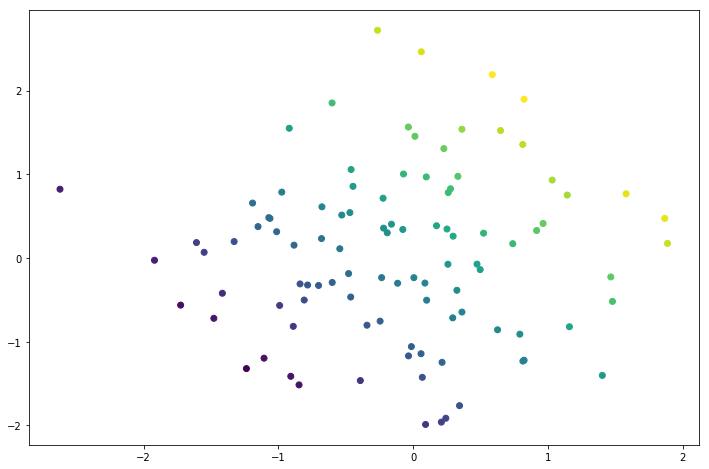

In [2]:
plt.figure(figsize=(12,8))
X, y = datasets.make_regression(n_features = 2, n_informative = 2, random_state=42)
plt.scatter(x=X[:, 0], y=X[:, 1], c=y)
plt.show()

### Создадим классы согласно заданию

1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.)

2. Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

In [3]:
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

        
class Leaf:
    
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.prediction = np.mean(self.y) # среднее
        

class DecisionTreeRegressor:
    
    def __init__(self, min_samples_leaf=5, max_depth=None, max_features=None):
        self.min_samples_leaf = min_samples_leaf
        self.max_depth = max_depth
        self.max_features = max_features
        
    def dispersion(self, values):
        m = values.mean()
        return np.mean((values - m) ** 2)
    
    def quality(self, left_values, right_values, current_dispersion):
        p = float(left_values.shape[0]) / (left_values.shape[0] + right_values.shape[0])
        return current_dispersion - p * self.dispersion(left_values) - (1 - p) * self.dispersion(right_values)
    
    def split(self, x, y, index, t):
        left = np.where(x[:, index] <= t)
        right = np.where(x[:, index] > t)

        true_data = x[left]
        false_data = x[right]
        true_y = y[left]
        false_y = y[right]
        
        return true_data, false_data, true_y, false_y
    
    def find_best_split(self, x, y):
        current_dispersion = self.dispersion(y)

        best_t = None
        best_index = None
        best_quality = 0

        for index in range(self.n_features):
            t_values = x[:, index]
            for t in t_values:
                true_data, false_data, true_y, false_y = self.split(x, y, index, t)

                #  пропускаем разбиения, в которых в узле остается менее 5 объектов
                if len(true_data) < self.min_samples_leaf or len(false_data) < self.min_samples_leaf:
                    continue

                current_quality = self.quality(true_y, false_y, current_dispersion)
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index

        return best_quality, best_t, best_index    
  
    def build_tree(self, x, y, depth=0):
        quality, t, index = self.find_best_split(x, y)
        if quality == 0 or (self.max_depth and depth > self.max_depth):
            return Leaf(x, y)

        true_data, false_data, true_y, false_y = self.split(x, y, index, t)
        true_branch = self.build_tree(true_data, true_y, depth+1)
        false_branch = self.build_tree(false_data, false_y, depth+1)

        return Node(index, t, true_branch, false_branch)

    def print_tree(self):
        def print_node(node, spacing=""):
            if isinstance(node, Leaf):
                print(spacing + "Прогноз:", node.prediction)
                return

            print(spacing + 'Индекс', str(node.index))
            print(spacing + 'Порог', str(node.t))

            print (spacing + '--> True:')
            print_node(node.true_branch, spacing + "  ")

            print (spacing + '--> False:')
            print_node(node.false_branch, spacing + "  ")
        
        print_node(self.tree_)
    
    def fit(self, X, y):
        if self.max_features and self.max_features < X.shape[1]:
            self.n_features = self.max_features
        else:
            self.n_features = X.shape[1]

        self.tree_ = self.build_tree(X, y)
        return self

    def predict(self, X):
        def predict_object(obj, node):
            if isinstance(node, Leaf):
                return node.prediction
            if obj[node.index] <= node.t:
                return predict_object(obj, node.true_branch)
            else:
                return predict_object(obj, node.false_branch)

        y = []
        for obj in X:
            prediction = predict_object(obj, self.tree_)
            y.append(prediction)
        return y

In [4]:
def print_score(model, X_train, y_train, X_test, y_test):
    y_pred = model.predict(X_train)
    train_score = r2_score(y_train, y_pred)
    
    y_pred = model.predict(X_test)
    test_score = r2_score(y_test, y_pred)

    print(f'Train Score {train_score:0.4f}\nTest Score {test_score:0.4f}')
    return train_score, test_score

## Проверка решения

In [5]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.3, random_state = 1)

In [6]:
model = DecisionTreeRegressor()
model.fit(X_train, y_train)
model.print_tree()

Индекс 1
Порог 0.11092258970986608
--> True:
  Индекс 0
  Порог 0.24196227156603412
  --> True:
    Индекс 0
    Порог -0.8895144296255233
    --> True:
      Прогноз: -151.60596503865037
    --> False:
      Индекс 1
      Порог -0.3220615162056756
      --> True:
        Индекс 1
        Порог -1.168678037619532
        --> True:
          Прогноз: -113.12234795368772
        --> False:
          Прогноз: -84.09364501364462
      --> False:
        Прогноз: -38.77531989980311
  --> False:
    Индекс 1
    Порог -0.9093874547947389
    --> True:
      Прогноз: -23.4504745677586
    --> False:
      Прогноз: 11.09480500834991
--> False:
  Индекс 0
  Порог -0.6800247215784908
  --> True:
    Прогноз: -63.94204215541255
  --> False:
    Индекс 0
    Порог 0.33126343140356396
    --> True:
      Индекс 1
      Порог 1.0571222262189157
      --> True:
        Индекс 0
        Порог -0.16128571166600914
        --> True:
          Прогноз: 13.686461017729068
        --> False:
          Про

In [7]:
print_score(model, X_train, y_train, X_test, y_test)

Train Score 0.9022
Test Score 0.8615


(0.9022265188452246, 0.8615001836234027)

In [8]:
# min_samples_leaf = 1
model = DecisionTreeRegressor(min_samples_leaf=1)
model.fit(X_train, y_train)
print_score(model, X_train, y_train, X_test, y_test)

Train Score 1.0000
Test Score 0.8888


(1.0, 0.8888124432621697)

In [9]:
# max_features = 1
model = DecisionTreeRegressor(max_features=1)
model.fit(X_train, y_train)
print_score(model, X_train, y_train, X_test, y_test)
model.print_tree()

Train Score 0.5403
Test Score 0.5291
Индекс 0
Порог -0.3427145165267695
--> True:
  Индекс 0
  Порог -1.1063349740060282
  --> True:
    Прогноз: -142.07341164917338
  --> False:
    Индекс 0
    Порог -0.7020530938773524
    --> True:
      Прогноз: -70.33070071261763
    --> False:
      Индекс 0
      Порог -0.5297602037670388
      --> True:
        Прогноз: -16.070124913551847
      --> False:
        Прогноз: -50.18517377187141
--> False:
  Индекс 0
  Порог 0.6256673477650062
  --> True:
    Индекс 0
    Порог 0.06023020994102644
    --> True:
      Индекс 0
      Порог -0.11564828238824053
      --> True:
        Прогноз: 8.42835198478891
      --> False:
        Прогноз: 61.80042077570741
    --> False:
      Индекс 0
      Порог 0.24196227156603412
      --> True:
        Прогноз: -15.270939202513631
      --> False:
        Прогноз: 21.018822295806768
  --> False:
    Индекс 0
    Порог 0.9154021177020741
    --> True:
      Прогноз: 87.5196160249138
    --> False:
      Прог

In [10]:
# max_depth = 1
model = DecisionTreeRegressor(max_depth=1)
model.fit(X_train, y_train)
print_score(model, X_train, y_train, X_test, y_test)
model.print_tree()

Train Score 0.7097
Test Score 0.6324
Индекс 1
Порог 0.11092258970986608
--> True:
  Индекс 0
  Порог 0.24196227156603412
  --> True:
    Прогноз: -94.2236084507472
  --> False:
    Прогноз: -6.177834779704346
--> False:
  Индекс 0
  Порог -0.6800247215784908
  --> True:
    Прогноз: -63.94204215541255
  --> False:
    Прогноз: 100.61562662335766


In [11]:
model = DecisionTreeRegressor(min_samples_leaf=1)
model.fit(X_train, y_train)
train_score, test_score = print_score(model, X_train, y_train, X_test, y_test)

Train Score 1.0000
Test Score 0.8888


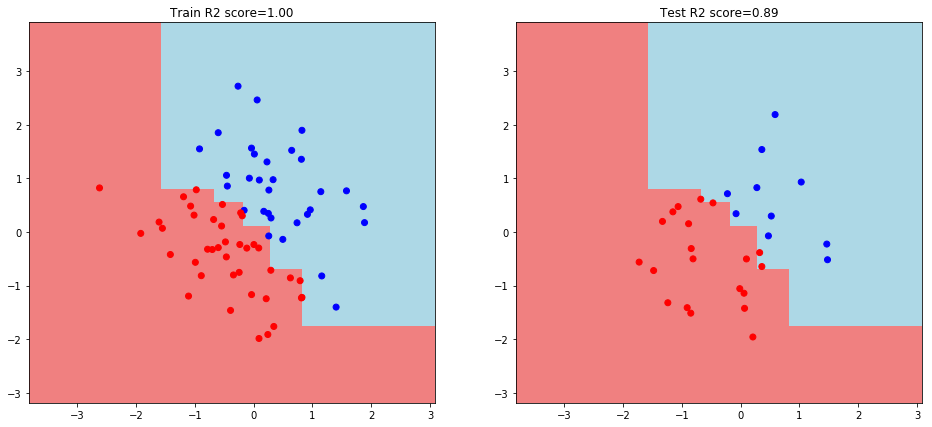

In [12]:
from matplotlib.colors import ListedColormap
light_colors = ListedColormap(['lightcoral', 'lightblue'])
colors = ListedColormap(['red', 'blue'])

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(X_train)
mesh_predictions = np.array(model.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(X_train[:, 0], X_train[:, 1], c = y_train, cmap = colors)
plt.title(f'Train R2 score={train_score:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(X_test[:, 0], X_test[:, 1], c = y_test, cmap = colors)
plt.title(f'Test R2 score={test_score:.2f}')
plt.show()